In [1]:
## Load libraries

import numpy as np
import cv2
from matplotlib import pyplot as plt
import torch
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize
import sys
sns.set(style="white")
%matplotlib inline
sys.path.append('../../utils')
from Model_utils.Model_funcs import *
from Data_proc_utils.Data_proc_funcs import *


In [2]:
feature_list_children = '../../data/data_full/feature_vectors/magface_feature_vectors/feat_img_children_full.list'
feature_list_adults = '../../data/data_full/feature_vectors/magface_feature_vectors/feat_img_adults_full.list'


def load_and_compute_similarity(feature_list, dtype=np.float32):
    # Load data
    image_names, ids, num_ids, norm_feats = load_magface_vectors(feature_list)

    # Convert dtype to reduce memory usage
    norm_feats = norm_feats.astype(dtype)

    # Compute similarity matrix incrementally if possible
    sim_mat = np.dot(norm_feats, norm_feats.T)

    return image_names, ids, num_ids, sim_mat

# Load and compute for children
image_names_c, ids_c, num_ids_c, sim_mat_c = load_and_compute_similarity(feature_list_children)

# Load and compute for adults
image_names_a, ids_a, num_ids_a, sim_mat_a = load_and_compute_similarity(feature_list_adults)


# Dataframes with info, removes names not in magface results
children_all = pd.read_csv('../../data/image_info_csvs/final_filtered_children_df_BIBEL.csv') #erstat med den opdaterede
children_all = children_all[children_all.image_name.isin(image_names_c)]
adults_all = pd.read_csv('../../data/image_info_csvs/final_filtered_adults_df_BIBEL.csv') #erstat med den opdaterede
adults_all = adults_all[adults_all.image_name.isin(image_names_a)] # OBS, this operation because some magface images has not been through all adults images.


In [3]:
# from Data_proc_utils.Data_proc_funcs import *
# random_states = [42]

# children_balanced_df_1 = balance_child_data(children_all, print_stats=True, random_state=random_states[0])
# adults_balanced_df_1 = balance_adults_data_enrolled(children_balanced_df_1, adults_all, print_stats=True, random_state=random_states[0])


In [4]:
import numpy as np
import pandas as pd



# Function to calculate FNIR and get high threshold list
def GET_SIM_MATRIX_HIGH_TH(enrolled_sim_mat, sim_mat, enrolled_ids, enrolled_num_id, ids, image_names, thold=0.5):
    M_d_set = set(enrolled_ids)
    M_d_set_len = len(enrolled_sim_mat)
    neg_ref = 0
    high_threshold_list = []

    for m_i, id_now in enumerate(ids):
        if id_now in M_d_set:
            mated_ids_exact = [id == id_now for id in ids]
            mated_sim_scores_slice = sim_mat[m_i]
            mated_sim_scores = [(score, image_names[j]) for j, (score, keep) in enumerate(zip(mated_sim_scores_slice, mated_ids_exact)) if keep]
            mated_sim_scores_sorted = sorted(mated_sim_scores, reverse=True, key=lambda x: x[0])
            high_threshold_list.extend([(image_names[m_i], img_name, score) for score, img_name in mated_sim_scores_sorted[:3]])

    for i in range(M_d_set_len):
        probe = enrolled_num_id[i]
        classified_negative_list = enrolled_sim_mat[i] <= thold
        classified_negative_idx = list(np.where(classified_negative_list)[0])
        if probe in [enrolled_num_id[idx] for idx in classified_negative_idx]:
            neg_ref += 1

    fnir = neg_ref / M_d_set_len if M_d_set_len > 0 else 0
    return fnir, high_threshold_list


In [5]:
enrolled_ids_a = ids_a
enrolled_sim_mat_a = sim_mat_a

# ### Compute FNIR and high threshold list
FNIR_a, high_threshold_results_a = GET_SIM_MATRIX_HIGH_TH(
    enrolled_sim_mat_a, sim_mat_a, enrolled_ids_a, num_ids_a, ids_a, image_names_a, thold=0.48)

# print("Children:", high_threshold_results_c)
print("Adults:", high_threshold_results_a)


Adults: [('m.05pnr7_0003', 'm.05pnr7_0003', 1.0), ('m.05pnr7_0003', 'm.05pnr7_0002', 0.54354143), ('m.05pnr7_0003', 'm.05pnr7_0004', 0.4412958), ('m.05pnr7_0002', 'm.05pnr7_0002', 0.9999999), ('m.05pnr7_0002', 'm.05pnr7_0003', 0.54354143), ('m.05pnr7_0002', 'm.05pnr7_0004', 0.47158152), ('m.05pnr7_0001', 'm.05pnr7_0001', 1.0), ('m.05pnr7_0001', 'm.05pnr7_0003', 0.34194666), ('m.05pnr7_0001', 'm.05pnr7_0002', 0.2509334), ('m.05pnr7_0004', 'm.05pnr7_0004', 0.9999995), ('m.05pnr7_0004', 'm.05pnr7_0002', 0.47158152), ('m.05pnr7_0004', 'm.05pnr7_0003', 0.4412958), ('m.0qsc14x_0003', 'm.0qsc14x_0003', 0.9999999), ('m.0qsc14x_0003', 'm.0qsc14x_0002', 0.56949645), ('m.0qsc14x_0003', 'm.0qsc14x_0001', 0.49318), ('m.0qsc14x_0002', 'm.0qsc14x_0002', 1.0000002), ('m.0qsc14x_0002', 'm.0qsc14x_0003', 0.56949645), ('m.0qsc14x_0002', 'm.0qsc14x_0001', 0.40757298), ('m.0qsc14x_0001', 'm.0qsc14x_0001', 1.0), ('m.0qsc14x_0001', 'm.0qsc14x_0003', 0.49318), ('m.0qsc14x_0001', 'm.0qsc14x_0002', 0.40757298),

In [6]:
df = pd.DataFrame(high_threshold_results_a, columns=['Probe Image', 'Reference Image', 'Similarity Score'])

# Filter out rows where the similarity score is greater than 0.999
df = df[df['Similarity Score'] <= 0.999]

In [7]:
# Add Identity
df = df.sort_values(by='Similarity Score', ascending=False)
df['Probe Image Identity'] = df['Probe Image'].str.split('_00').str[0]
df['Reference Image Identity'] = df['Reference Image'].str.split('_00').str[0]

In [8]:
# split them in mated and non-mated
mated_df = df[df['Probe Image Identity'] == df['Reference Image Identity']]
non_mated_df = df[df['Probe Image Identity'] != df['Reference Image Identity']]


# OFIQ added

In [9]:
OFIQ_a = pd.read_csv('../../data/OFIQ_results/table_adults_all_in_one.csv')
merged_df_probe = pd.merge(mated_df, OFIQ_a, left_on='Probe Image', right_on='image_name')


In [10]:
len(merged_df_probe)

39960

# filtering the worst out

In [11]:
merged_df_probe = merged_df_probe.sort_values(by='Similarity Score', ascending=False)
The_bottom_identities = merged_df_probe['Probe Image Identity'].tail(11000)

In [12]:
# remove rows if mated_df['Probe Image Identity] in The_bottom_identities

mask = ~merged_df_probe['Probe Image Identity'].isin(The_bottom_identities)

# Apply the mask to filter the DataFrame
filtered_mated_df = merged_df_probe[mask]

# Display or use the filtered DataFrame
# mated_df = filtered_mated_df
# len(mated_df)

In [13]:
filtered_mated_df = filtered_mated_df.sort_values(by='Similarity Score', ascending=False)

indices_to_remove = filtered_mated_df.tail(7000).index[1::2]  # Start from the second element and take every second element
merged_df_probe_0 = filtered_mated_df.drop(indices_to_remove)

merged_df_probe_0 = merged_df_probe_0.sort_values(by='Similarity Score', ascending=False)


indices_to_remove = merged_df_probe_0.tail(1500).index[1::2]  # Start from the second element and take every second element
merged_df_probe = merged_df_probe_0.drop(indices_to_remove)

# filtering based on standard deviation

In [14]:
# først check om det er disse, der er højt korreleret med sim scores
correlation_matrix = merged_df_probe.corr()
print(correlation_matrix['Similarity Score'].sort_values(ascending=False)[:5])

# highest_top = correlation_matrix.drop('Similarity Score', errors='ignore').idxmax()  # Ignore self-correlation


Similarity Score              1.000000
UnifiedQualityScore           0.191390
UnifiedQualityScore.scalar    0.191151
HeadPoseYaw.scalar            0.176529
LuminanceMean.scalar          0.135106
Name: Similarity Score, dtype: float64


In [15]:
def remove_outliers(df):
    # Calculate the standard deviation for HeadPoseYaw.scalar and HeadPoseRoll.scalar for each identity
    sd_metrics = df.groupby('Probe Image Identity').agg({
        'HeadPoseYaw.scalar': 'std',
        'HeadPoseRoll.scalar': 'std'
    })

    # Calculate the average SD across all identities for each metric
    avg_yaw_sd = sd_metrics['HeadPoseYaw.scalar'].median()
    avg_roll_sd = sd_metrics['HeadPoseRoll.scalar'].median()

    # Identify identities with SD greater than the average
    high_sd_identities_yaw = sd_metrics[sd_metrics['HeadPoseYaw.scalar'] > avg_yaw_sd].index
    high_sd_identities_roll = sd_metrics[sd_metrics['HeadPoseRoll.scalar'] > avg_roll_sd].index

    # Create an empty list to store indices of rows to drop
    indices_to_drop = []

    # Process each identity with high HeadPoseYaw.scalar SD
    for identity in high_sd_identities_yaw:
        subset = df[df['Probe Image Identity'] == identity]
        mean_value = subset['HeadPoseYaw.scalar'].median()
        subset['diff_from_mean_yaw'] = (subset['HeadPoseYaw.scalar'] - mean_value).abs()
        max_diff_index = subset['diff_from_mean_yaw'].idxmax()
        indices_to_drop.append(max_diff_index)

    # Process each identity with high HeadPoseRoll.scalar SD
    for identity in high_sd_identities_roll:
        subset = df[df['Probe Image Identity'] == identity]
        mean_value = subset['HeadPoseRoll.scalar'].median()
        subset['diff_from_mean_roll'] = (subset['HeadPoseRoll.scalar'] - mean_value).abs()
        max_diff_index = subset['diff_from_mean_roll'].idxmax()
        indices_to_drop.append(max_diff_index)

    # Drop the identified outliers from HeadPoseYaw.scalar and HeadPoseRoll.scalar
    df = df.drop(indices_to_drop)

    # Update list of remaining identities after removing those with high HeadPoseYaw.scalar or HeadPoseRoll.scalar SD
    remaining_identities = set(df['Probe Image Identity']) - set(high_sd_identities_yaw) - set(high_sd_identities_roll)

    # For remaining identities, process based on UnifiedQualityScore.scalar
    for identity in remaining_identities:
        subset = df[df['Probe Image Identity'] == identity]
        if 'UnifiedQualityScore.scalar' in subset.columns:
            neutrality_sd = subset['UnifiedQualityScore.scalar'].std()
            mean_neutrality = subset['UnifiedQualityScore.scalar'].median()
            subset['diff_from_neutrality_mean'] = (subset['UnifiedQualityScore.scalar'] - mean_neutrality).abs()
            max_diff_neutrality_index = subset['diff_from_neutrality_mean'].idxmax()
            df = df.drop(max_diff_neutrality_index)

    return df


In [16]:
merged_df_probe

Probe Image Reference Image  Similarity Score Probe Image Identity  \
0      m.0gdkhck_0004  m.0gdkhck_0002          0.969252            m.0gdkhck   
2      m.0gdkhck_0002  m.0gdkhck_0004          0.969252            m.0gdkhck   
4       m.09jvjz_0002   m.09jvjz_0004          0.964097             m.09jvjz   
6       m.09jvjz_0004   m.09jvjz_0002          0.964097             m.09jvjz   
8       m.02hd3q_0002   m.02hd3q_0003          0.963528             m.02hd3q   
...               ...             ...               ...                  ...   
33369    m.0ql9l_0001    m.0ql9l_0002          0.389706              m.0ql9l   
31949  m.0j445s5_0003  m.0j445s5_0001          0.389661            m.0j445s5   
17911   m.0jwkl__0001   m.0jwkl__0003          0.389564             m.0jwkl_   
27577   m.020nvl_0003   m.020nvl_0001          0.389438             m.020nvl   
33408  m.02z87km_0001  m.02z87km_0002          0.389227            m.02z87km   

      Reference Image Identity  \
0                    m.0gdkhck   
2                    m.0gdkhck   
4                     m.09jvjz   
6                     m.09jvjz   
8                     m.02hd3q   
...                        ...   
33369                  m.0ql9l   
31949                m.0j445s5   
17911                 m.0jwkl_   
27577                 m.020nvl   
33408                m.02z87km   

                                                Filename  UnifiedQualityScore  \
0      ../../../data/tests/images/adults_full_final/m...            20.462954   
2      ../../../data/tests/images/adults_full_final/m...            19.754864   
4      ../../../data/tests/images/adults_full_final/m...            24.546780   
6      ../../../data/tests/images/adults_full_final/m...            27.114086   
8      ../../../data/tests/images/adults_full_final/m...            25.618225   
...                                                  ...                  ...   
33369  ../../../data/tests/images/adults_full_final/m...            15.648363   
31949  ../../../data/tests/images/adults_full_final/m...            18.622965   
17911  ../../../data/tests/images/adults_full_final/m...            23.860506   
27577  ../../../data/tests/images/adults_full_final/m...            23.262472   
33408  ../../../data/tests/images/adults_full_final/m...            21.387129   

       BackgroundUniformity  IlluminationUniformity  LuminanceMean  ...  \
0                 64.714091                0.337925       0.696788  ...   
2                 27.152722                0.314050       0.677447  ...   
4                100.020727                0.357208       0.052451  ...   
6                 58.457280                0.363636       0.055159  ...   
8                 75.721345                0.306063       0.361435  ...   
...                     ...                     ...            ...  ...   
33369             79.888828                0.598633       0.316705  ...   
31949             20.056685                0.240816       0.050959  ...   
17911             40.892251                0.113866       0.151893  ...   
27577             63.539297                0.781636       0.231085  ...   
33408            197.986879                0.534860       0.110857  ...   

       DownwardCropOfTheFaceImage.scalar  UpwardCropOfTheFaceImage.scalar  \
0                                     34                                9   
2                                     34                               10   
4                                      6                                1   
6                                      5                                1   
8                                     11                                2   
...                                  ...                              ...   
33369                                  5                                1   
31949                                 13                                3   
17911                                  4                                1

In [17]:


df = merged_df_probe
df_cleaned_first = remove_outliers(df)
df_cleaned = remove_outliers(df_cleaned_first)

/tmp/ipykernel_106928/867153917.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['diff_from_mean_yaw'] = (subset['HeadPoseYaw.scalar'] - mean_value).abs()
/tmp/ipykernel_106928/867153917.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['diff_from_mean_yaw'] = (subset['HeadPoseYaw.scalar'] - mean_value).abs()
/tmp/ipykernel_106928/867153917.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [18]:
len(df_cleaned)

7627

# DET

In [19]:
# mated_scores1 = merged_df_probe['Similarity Score']
# nonmated_scores1 = merged_df_probe['Similarity Score']

from DET_utils.DET import DET
from DET_utils.DET_plots import *

mated_scores1 = df_cleaned['Similarity Score']
nonmated_scores1 = df_cleaned['Similarity Score']

In [20]:
stats_system1_df = descriptive_statistics(mated_scores1, nonmated_scores1)
stats_system1_df.round(round_digits).style.hide_index()

/tmp/ipykernel_106928/3645691370.py:2: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  stats_system1_df.round(round_digits).style.hide_index()


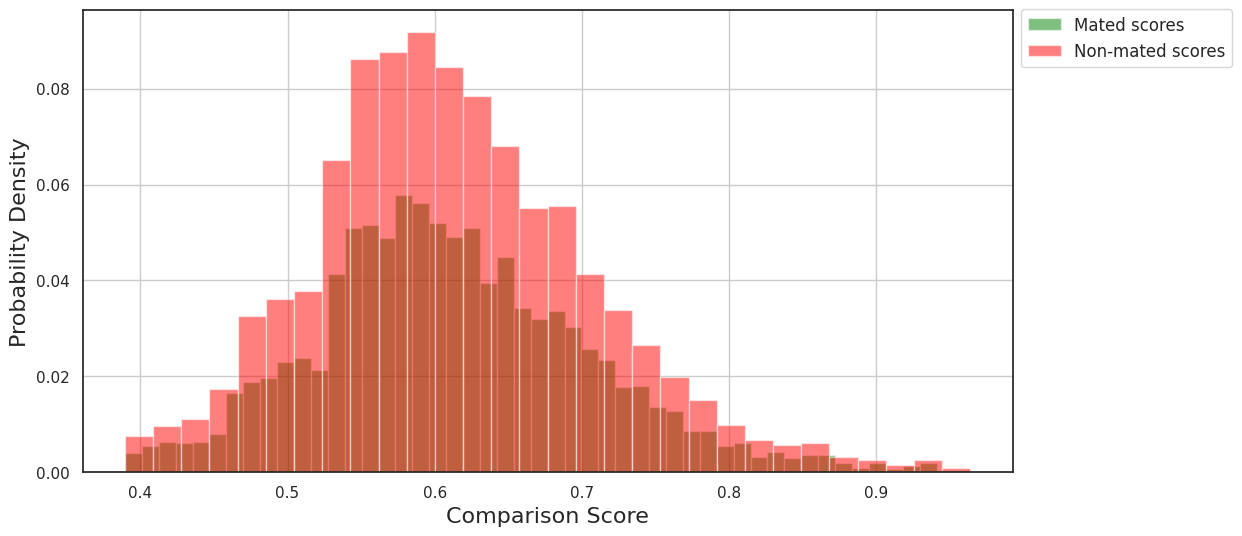

In [21]:
plot_histogram(mated_scores1, nonmated_scores1, normalise=True)

In [22]:
df_cleaned.to_csv('../../data/image_info_csvs/Image_pairs_similarityscores_OFIQ_worst_dropped.csv')

: 